# Simulation Implementation of Transient Injection Experiment
## Use of transient Epo and stepwise IL-17 introduction

In [3]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns


from dataclasses import dataclass, field
from scipy.optimize import fsolve, minimize
from scipy.integrate import solve_ivp
from typing import Optional, Callable, Dict, Any, Tuple, List
from typing import Callable, Optional
import types

from dataclasses import dataclass, field

from IPython.display import Image

import matplotlib.style as style
style.core.USER_LIBRARY_PATHS.append("/Users/qiuwu/.matplotlib/stylelib")

qw_light = "./qw_light_paper.mplstyle"
plt.style.use(qw_light)


/Users/qiuwu/miniconda3/envs/py3.10/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# Toy model simulations for IL17/Epo synergy

## Background and definitions:

#### Model schema:

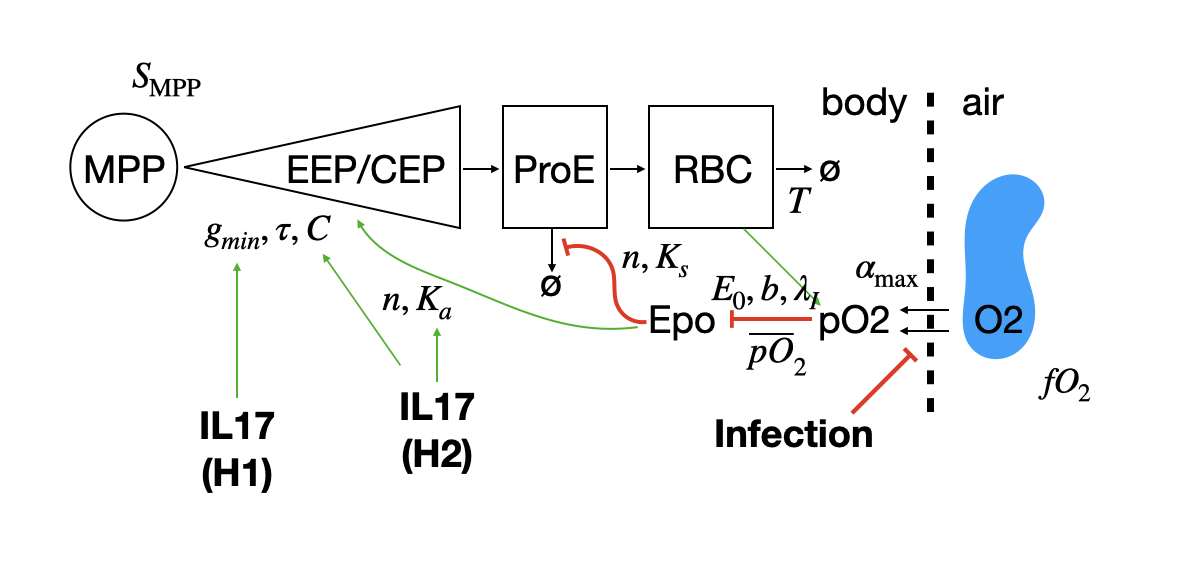

In [4]:
Image(filename="imgs/model_schematic.png", width=600)

### Model Equations

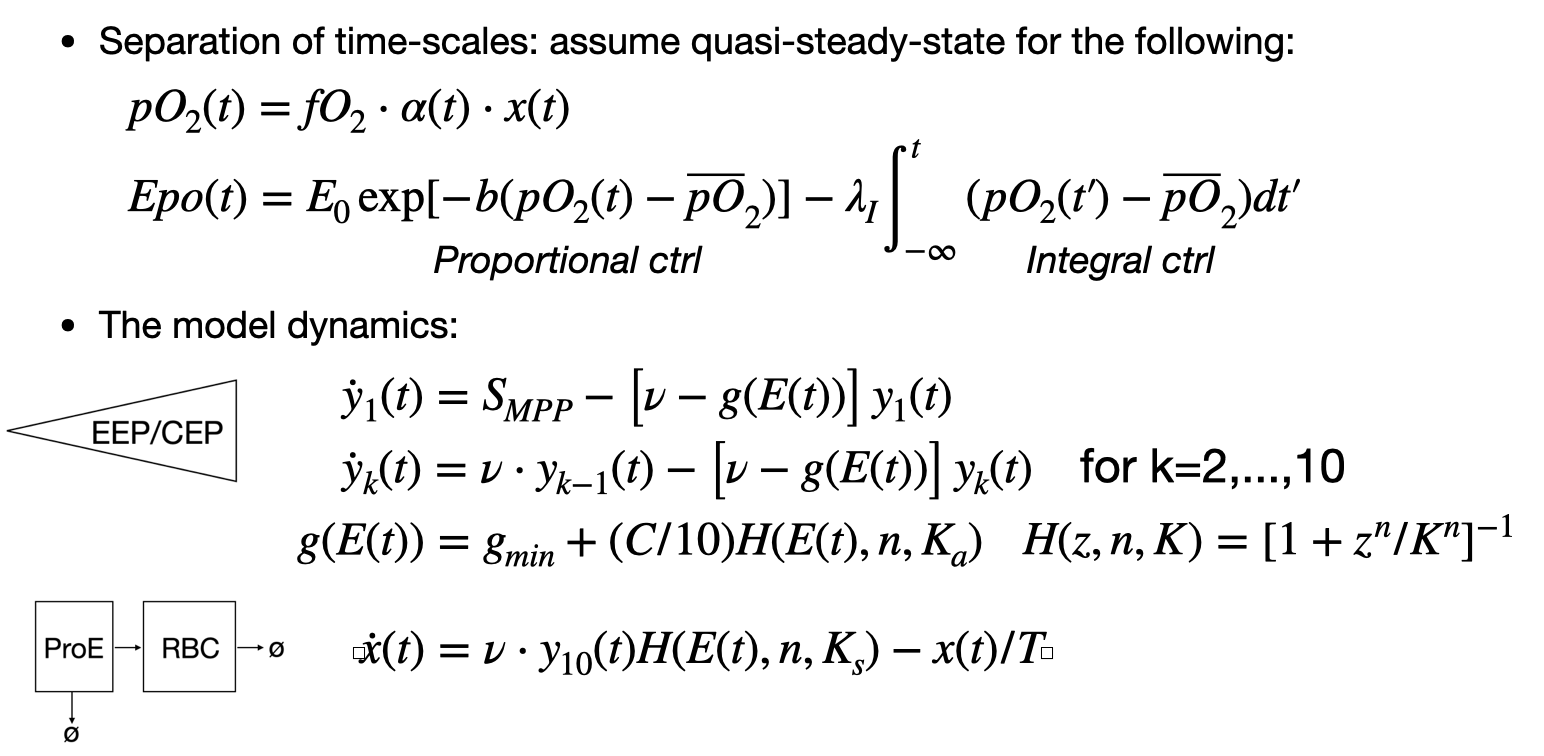

In [5]:
Image(filename="imgs/model_eqns.png", width=600)

### Parameter Choices

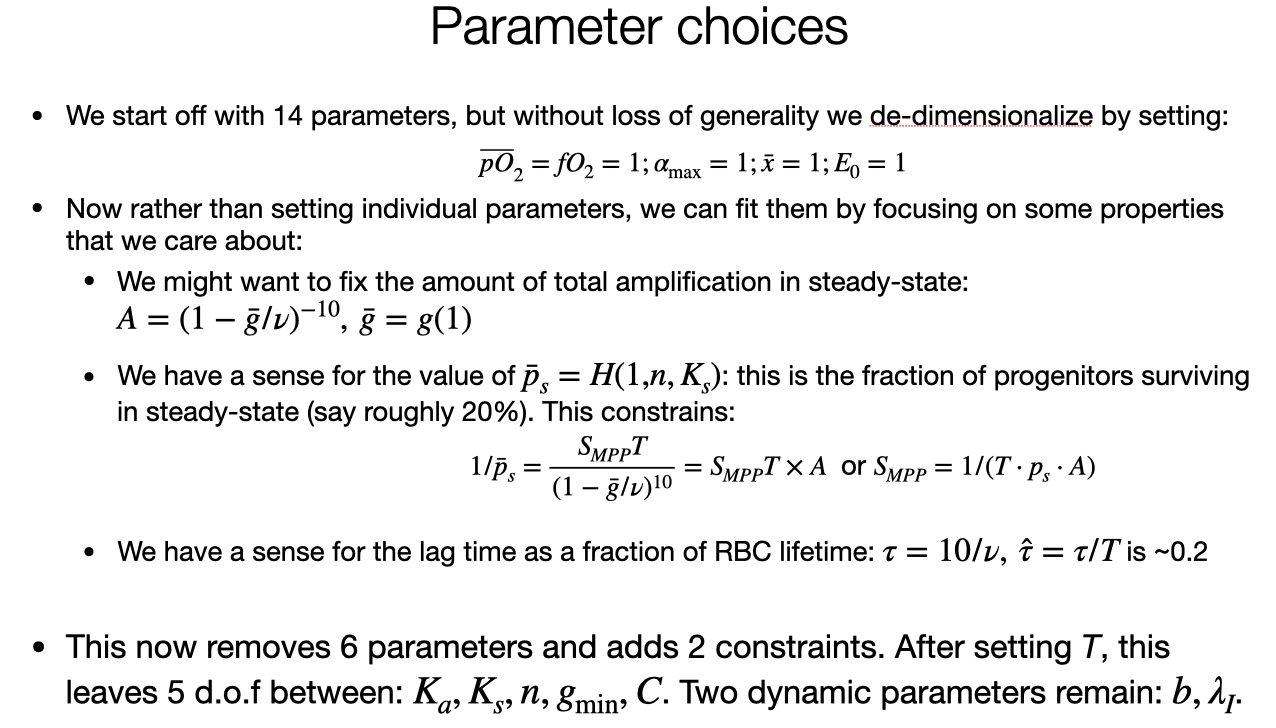

In [6]:
Image(filename="imgs/model_constraints.png", width=600)

## Setting up the model and the simulations

In [1379]:
@dataclass
class Simulation:
    N: float = 20 # Number of transit amplifying compartments
    
    epo_normalization: str = 'K1' # Set to either 'K1' or to 'E_0' to decide which will be set to 1.0
                                  # For scanning baseline designs, use 'E_0' (to keep baseline at E=1)
                                  # For physiological tuning, use 'K1' (because otherwise tuning will change K1)
    
    T: float = 40  # Lifetime of RBCs (days)
    tau: float = 7 # Mean time to propagate through progenitor pool

    K_r21: float = 2.0 #1.0 #3  # Ratio of K2/K1. Note that K2 is higher, because early compartment less sensitive

    E_0: float = 1.0 ### Preset to 1 
    K1: float = 1.0    # Ks - Epo concentration to achieve 50% survival of final RBC progenitors
    
    n_s: int = 2
    n_a: int = 2 # hill coefficient of Epo response
   
    pSurv: float = 0.2 # Expected Epo-dependent survival rate of progenitors in steady-state
    # baselineAmp: float = 100 # Expected baseline amplification of progenitors

    
    # Trivial parameters:
    pO2_tgt: float = 1.0  # Target pO2
    fO2: float = 1.0      # External available O2
    xBar: float = 1.0 # Cell count at steady state (defined as 1.0)

    
    gmin: float = 0.65 #0.7 #get_gmin(1000, 20, 7) # Baseline progenitor proliferaion at st-state
    #gmax: float = 2
    del_g: float = 0.65 #0.7 #0.5  #(gmax-gmin)
    S_mpp = 1/8000
    
    # Inflammation dynamics:
    alpha_max: float = 1.0 # Baseline absorbance (per unit x), pO2=fO2*x*alpha
    alpha_min: float = 1.0 # Minimum absorbance (lung infection) (per unit x) - when set to max, no disease
    alpha_T: float = 0.001  # Time (days) to reach minimum absorbance
    custom_alpha: Optional[Callable] = None  # Optional custom alpha function
                                            # alpha(self,t), to replace the default function
      
    # Feedback controller
    b: float = 5  # Sensitivity of Epo to pO2 deviation from target (dlog(Epo)/d(pO2))
    L_I: float = 0.05 # Strength of integral control
    integral_term: float = field(init=False, default=0.0)
    _last_t: float = 0.0

 
    # INITIALIZATION SUBROUTINES
    # ==========================
    def __init__(self):
            
        self.alpha_max = self.pO2_tgt / (self.fO2 * self.xBar)  # effective absorbance per RBC
        self.nu = self.N / self.tau  # 1/Lifetime in each transitional state (days)
        
    def __post_init__(self):
        self.alpha_max = self.pO2_tgt / (self.fO2 * self.xBar)  # effective absorbance per RBC
        self.nu = self.N / self.tau  # 1/Lifetime in each transitional state (days)
        
        # Replace alpha function with custom input if provided:
        if self.custom_alpha is not None:
            self.alpha = types.MethodType(self.custom_alpha, self)
        else:
            self.alpha = self.default_alpha

    # THE MODEL EQUATIONS
    # ==========================        
    def H(self, z, K, n):
        return np.abs(z) ** n / (np.abs(z) ** n + K ** n)

        
    def g(self, E_t, K2):
        #return self.gmin + (self.gmax - self.gmin) * self.H(E_t, K2, self.n_a)
        return self.gmin + self.del_g * self.H(E_t, K2, self.n_a)
    

    def S(self, E_t, K1, y10):
        return self.nu * self.H(E_t, K1, self.n_s) * y10


    def default_alpha(self, t):
        return self.alpha_min + (self.alpha_max - self.alpha_min) * np.exp(-t / self.alpha_T)

    def pO2(self, x, alpha_t):
        return self.fO2 * x * alpha_t

    def E(self, t, x):            
        pO2_diff = self.pO2(x, self.alpha(t)) - self.pO2_tgt
        if t == 0:
            self.integral_term = 0  # Reset integral term at t=0
        else:
            self.integral_term += pO2_diff * (t - getattr(self, '_last_t', 0))  # Accumulate the integral term
        self._last_t = t  # Update the last time point
        return self.E_0 * np.exp(-self.b * pO2_diff) - self.L_I * self.integral_term

    # The following are the dynamical equations themselves:
    def model(self, t, variables):
        x, *y = variables

        E_t = self.E(t, x)
        g_t = self.g(E_t, self.K2)

        dxdt = self.S(E_t, self.K1, y[-1]) - x / self.T

        dydt = [0] * self.N  # Initialize list of progenitor states
        dydt[0] = self.S_mpp - (self.nu - g_t) * y[0]  # First progenitor
        for i in range(1, self.N):
            dydt[i] = self.nu * y[i - 1] - (self.nu - g_t) * y[i]  # Subsequent progenitors

        return [dxdt] + dydt  # Convert into a list and return

    
    
    # SUBROUTINES TO FIT E0 OR K1 UNITS FROM STEADY-STATE REQUIREMENTS
    # ================================================================
    
    # IF FITTING E_0 WITH UNITS OF K1:
    def steady_state_equations_E0(self, E_0):
        g0 = self.g(E_0,self.K2)
        
        log_y = [np.log(self.S_mpp / (self.nu - g0))]
        for i in range(1, self.N):
            log_y.append( log_y[i - 1] + np.log(self.nu / (self.nu - g0)) )
        xBar = self.S(E_0, self.K1, np.exp(log_y[-1])) * self.T
        return (xBar - self.xBar)**2

    
    def calculate_E0(self):
        initial_guess = 1.0
        #E0_solution = fsolve(self.steady_state_equations, initial_guess,)[0]
        E0_solution = minimize(self.steady_state_equations_E0, 
                               x0=[initial_guess], bounds=[(1e-3, 20)], 
                               tol=1e-30, options={'maxiter': 1000}).x[0]
        return E0_solution

    
    # IF FITTING K1 WITH UNITS OF E_0:
    def steady_state_equations_K1(self, K1):
        K2 = self.K_r21 * K1
        g0 = self.g(self.E_0, K2)

        log_y = [np.log(self.S_mpp / (self.nu - g0))]
        for i in range(1, self.N):
            log_y.append( log_y[i - 1] + np.log(self.nu / (self.nu - g0)) )
        xBar = self.S(self.E_0, K1, np.exp(log_y[-1])) * self.T
        return (self.xBar - xBar)**2


    def calculate_K1(self):        
        initial_guess = 1.0
        K1_solution = minimize(self.steady_state_equations_K1, x0=[initial_guess], bounds=[(1e-3, 20)]).x[0]
        return K1_solution

    # THE SUBROUTINE THAT SETS THE MISSING PARAMTER (K1 OR E0) AND GETS STEADY-STATE:
    def initialize_steady_state(self):
        if self.epo_normalization == 'K1':
            self.K1 = self.calculate_K1()
            #print(f'{self.K1}')
            self.K2 = self.K_r21 * self.K1
        elif self.epo_normalization == 'E_0':
            self.K2 = self.K_r21 * self.K1
            self.E_0 = self.calculate_E0()
        else:
            raise ValueError("epo_normalization must be 'E_0' or 'K1' only.")
            
        
        g0 = self.g(self.E_0,self.K2)

        self.y_ss = [self.S_mpp / (self.nu - g0)]
        for i in range(1, self.N):
            self.y_ss.append(self.y_ss[i - 1] * self.nu / (self.nu - g0))
        
        # print(f"Steady state values: E_0 = {self.E_0}, xBar = {self.xBar}, y_ss = {self.y_ss}")
        return self.xBar, self.y_ss

    def solve_steady_state(self):
        g0 = self.g(self.E_0,self.K2)
  
        self.y_ss = [self.S_mpp / (self.nu - g0)]
        for i in range(1, self.N):
            self.y_ss.append(self.y_ss[i - 1] * self.nu / (self.nu - g0))
        
        return self.xBar, self.y_ss


    # POST-RUN DATA ANALYSIS SUBROUTINES
    # ==================================
    def find_time_for_midpoint(self, t, x):
        midpoint_value = 0.5 * (np.max(x) + np.min(x))

        for i in range(len(x) - 1, 0, -1):
            if (x[i] - midpoint_value) * (x[i - 1] - midpoint_value) <= 0:  # Crossing midpoint_value
                return t[i]
        return None  # Return None if no crossing is found

    def find_time_for_O2(self, t, x):
        target_value = 0.95
        
        for i in range(1, len(x)):
            if x[i - 1] < target_value <= x[i]:  # Crosses from below to above
                if x[i] == target_value:
                    return t[i]
                elif x[i - 1] == target_value:
                    return t[i - 1]
                else:
                    return t[i]
        return None  # Return None if no crossing is found  

    
    # THE SUBROUTINE THAT RUNS THE SIMULATION AND GENERATES POST-RUN ANALYSES
    # =======================================================================    
    #def simulate(self, t_span, t_eval, perturbations: Optional[Dict[str, float]] = None):
        
    def simulate(self, t_span, t_eval, K_r21_duration=1.0):
    
        perturbation_times = [t_span[0]] + [pt[0] for pt in self.perturbations if t_span[0] <= pt[0] <= t_span[1]] + [t_span[1]]
        E_values = [0] + [pt[1] for pt in self.perturbations]
        K_r21_values = [0] + [pt[2] for pt in self.perturbations]
        gmin_values = [0] + [pt[3] for pt in self.perturbations]
        dg_values = [0] + [pt[4] for pt in self.perturbations]
        
        all_results = {
            't': [],
            'x': [],
            'y': np.empty((self.N, 0)),
            'E': [],
            'K2': [],
            'alpha': [],
            'pO2': [],
            'surv': [],
            'flux': []
        }
        
        initial_conditions = None
        original_K_r21 = self.K_r21
        original_gmin = self.gmin
        original_dg = self.del_g
        
        for i in range(len(perturbation_times) - 1):
            #print(i)
            t_start = perturbation_times[i]
            t_end = perturbation_times[i + 1]
            
            # Determine the evaluation points within this segment
            t_eval_segment = t_eval[(t_eval >= t_start) & (t_eval <= t_end)]


            if initial_conditions is None:
                self.__init__()
                self.xBar, self.y_ss = self.initialize_steady_state()
                initial_conditions = [self.xBar] + self.y_ss
                self.__post_init__()
            else:
                initial_conditions = last_conditions
                self.E_0 += E_values[i]
                #self.E_0 += self.E_0* E_values[i]



        
            # If K_r21 is perturbed, handle it within the segment
            if K_r21_values[i] != 0:
                # Perturb K_r21 and solve for the duration of the perturbation
                self.K_r21 = K_r21_values[i]
                self.del_g = dg_values[i]
                self.gmin = gmin_values[i]
                self.K2 = self.K1 * self.K_r21
                
                segment_end = min(t_end, t_start + K_r21_duration)
                t_eval_segment_perturbed = t_eval_segment[t_eval_segment <= segment_end]
                
                sol_perturbed = solve_ivp(self.model, (t_start, segment_end), initial_conditions, t_eval=t_eval_segment_perturbed, method='BDF')
                
                # Reset K_r21 after the perturbation
                self.K_r21 = original_K_r21
                self.del_g = original_dg
                self.gmin  = original_gmin
                self.K2    = self.K1 * self.K_r21
                
                # Continue solving for the rest of the segment without perturbation
                if segment_end < t_end:
                    initial_conditions = sol_perturbed.y[:, -1]  # Update initial conditions for the next segment
                    t_eval_segment_remaining = t_eval_segment[t_eval_segment > segment_end]
                    sol_remaining = solve_ivp(self.model, (segment_end, t_end), initial_conditions, t_eval=t_eval_segment_remaining, method='BDF')
                    
                    # Concatenate the solutions manually
                    sol_t = np.concatenate((sol_perturbed.t, sol_remaining.t))
                    sol_y = np.concatenate((sol_perturbed.y, sol_remaining.y), axis=1)
                else:
                    sol_t = sol_perturbed.t
                    sol_y = sol_perturbed.y
            else:
                # Solve the entire segment without perturbing K_r21
                sol = solve_ivp(self.model, (t_start, t_end), initial_conditions, t_eval=t_eval_segment, method='BDF')
                sol_t = sol.t
                sol_y = sol.y
            
            last_conditions = sol_y[:, -1]
            
            # Append segment results
            all_results['t'].extend(sol_t)
            all_results['x'].extend(sol_y[0])
            all_results['y'] = np.hstack((all_results['y'], sol_y[1:]))
            E_t_segment = [self.E(t, x) for t, x in zip(sol_t, sol_y[0])]
            all_results['E'].extend(E_t_segment)
            all_results['K2'].append(self.K2)  # Track K2 over time
            alpha_t_segment = [self.alpha(t) for t in sol_t]
            all_results['alpha'].extend(alpha_t_segment)
            pO2_t_segment = [self.pO2(x, alpha) for x, alpha in zip(sol_y[0], alpha_t_segment)]
            all_results['pO2'].extend(pO2_t_segment)
            all_results['surv'].extend([self.H(E, self.K1, self.n_s) for E in E_t_segment])
            all_results['flux'].extend([self.nu * y10 for y10 in sol_y[-1]])
        
        t_mid = self.find_time_for_midpoint(np.array(all_results['t']), np.array(all_results['pO2']))
        t_O2 = self.find_time_for_O2(np.array(all_results['t']), np.array(all_results['pO2']))
        
        self.results = {
            't': np.array(all_results['t']), 
            'x': np.array(all_results['x']), 
            'y': all_results['y'], 
            'E': np.array(all_results['E']), 
            'K2': np.array(all_results['K2']), 
            'alpha': np.array(all_results['alpha']), 
            'pO2': np.array(all_results['pO2']), 
            'surv': np.array(all_results['surv']), 
            'flux': np.array(all_results['flux']), 
            't_midO2': t_mid, 
            't_O2_rec': t_O2
        }

        return self.results



## Implementing Tuning via Direct Control or Sensitivity

In [1859]:
K_r21_baseline = 8
K_r21_tuned = 2

gmin_baseline = 0.65
gmin_tuned = 1

dg_baseline = 1.3
dg_tuned = 1.3

Epo_no_inj = 0
Epo_inj    = 5

# ##### TUNING BY DEL G
# K_r21_baseline = 2
# K_r21_tuned = 2

# gmin_baseline = 0.65
# gmin_tuned = 1

# dg_baseline = 0.65
# dg_tuned = 1.3

# Epo_no_inj = 0
# Epo_inj    = 5
# #####

tuning_dict = {
    'baseline_epo':{'epo_val':   Epo_inj,
                    'k_r21_val': K_r21_baseline, #10,    ## Default
                    'gmin_val':  gmin_baseline, #0.01       ## Default
                    'dg_val':    dg_baseline
                   },
    'no_epo_direct_control':{'epo_val': Epo_no_inj,
                    'k_r21_val': K_r21_baseline, #10,    ## Default
                    'gmin_val':  gmin_tuned,    #0.10    ## IL-17A adjusted for Flux
                    'dg_val':    dg_baseline
                  },
    
    'epo_and_direct_control':{'epo_val': Epo_inj,
                    'k_r21_val': K_r21_baseline,  #10,    ## Default
                    'gmin_val':  gmin_tuned,    #0.10    ## IL-17A adjusted for Flux
                    'dg_val':    dg_baseline
                  },

     'no_epo_sensitivity_tuning':{'epo_val': Epo_no_inj,
                     'k_r21_val': K_r21_tuned,# K_r21_baseline, #K_r21_tuned, # 4.5,   ## IL-17A adjusted for Sensitivity
                     'gmin_val':  gmin_baseline,    #0.10    ## IL-17A adjusted for Flux
                     'dg_val':    dg_tuned
                   },
    
     'sensitivity_tuning':{'epo_val': Epo_inj,
                     'k_r21_val': K_r21_tuned,#K_r21_baseline, #K_r21_tuned, # 4.5,   ## IL-17A adjusted for Sensitivity
                     'gmin_val':  gmin_baseline,    #0.10    ## IL-17A adjusted for Flux
                     'dg_val':    dg_tuned
                   }
                  
}

def plotting_features(results):
    plt.figure(figsize= (7,2))
    for key in results.keys():
        plt.subplot(1,3,1)
        plt.plot(results[key]['t'], results[key]['x']/results[key]['x'][0], label = key)
        plt.title('X(t)')
        plt.xlabel('Days')
        plt.ylabel('Fold-change\nover unperturbed')
        plt.subplot(1,3,2)
        plt.plot(results[key]['t'], results[key]['y'][-1]/results[key]['y'][-1][0], label = key)
        plt.title('Y10(t)')
        plt.xlabel('Days')
        plt.subplot(1,3,3)
        plt.plot(results[key]['t'], results[key]['E']/results[key]['E'][0], label = key)
        plt.legend(loc ='upper left',
                   bbox_to_anchor=(1,1))
        plt.title('E(t)')
        plt.xlabel('Days')
    plt.tight_layout()

def plotting_features_no_fc(results):
    plt.figure(figsize= (7,2))
    for key in results.keys():
        plt.subplot(1,3,1)
        plt.plot(results[key]['t'], results[key]['x'], label = key)
        plt.title('X(t)')
        plt.xlabel('Days')
        plt.ylabel('Raw Values')
        plt.subplot(1,3,2)
        plt.plot(results[key]['t'], results[key]['y'][-1], label = key)
        plt.title('Y10(t)')
        plt.xlabel('Days')
        plt.subplot(1,3,3)
        plt.plot(results[key]['t'], results[key]['E'], label = key)
        plt.legend(loc ='upper left',
                   bbox_to_anchor=(1,1))
        plt.title('E(t)')
        plt.xlabel('Days')
    plt.tight_layout()

In [1860]:
results = {}

## Set up span
t_span = [0,10]
t_eval = np.linspace(t_span[0], t_span[1], (t_span[1]*10)+1)

## Epo Baseline
epo_ind_sim = Simulation()
epo_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, gmin
    (day, 
     tuning_dict['baseline_epo']['epo_val'],
     tuning_dict['baseline_epo']['k_r21_val'],
     tuning_dict['baseline_epo']['gmin_val'],
     tuning_dict['baseline_epo']['dg_val']) for day in np.arange(1,4)
]
results['epo_only_flux_hyp'] = epo_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)

## IL17 flux tuning
il17_ind_sim = Simulation()
il17_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, gmin
    (day, 
     tuning_dict['no_epo_direct_control']['epo_val'],
     tuning_dict['no_epo_direct_control']['k_r21_val'],
     tuning_dict['no_epo_direct_control']['gmin_val'],
     tuning_dict['no_epo_direct_control']['dg_val']) for day in np.arange(1,4)
]
# Run the simulation with the perturbations applied
results['il17_only_flux_hyp'] = il17_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)


## Epo + Il17 via flux tunning
epoil17_ind_sim = Simulation()
epoil17_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, gmin
    (day, 
     tuning_dict['epo_and_direct_control']['epo_val'],
     tuning_dict['epo_and_direct_control']['k_r21_val'],
     tuning_dict['epo_and_direct_control']['gmin_val'],
     tuning_dict['epo_and_direct_control']['dg_val']) for day in np.arange(1,4)
]

# Run the simulation with the perturbations applied
results['epo_il17_flux_hyp'] = epoil17_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)



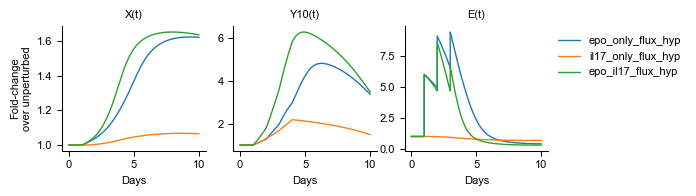

In [1861]:
## Plot results of flux tuning
plotting_features(results)
# plt.savefig('figures/direct_control_dynamics.pdf', bbox_inches='tight')


In [1862]:
results_sensitivity = {}

## Set up span
t_span = [0,10]
t_eval = np.linspace(t_span[0], t_span[1], (t_span[1]*10)+1)

## Epo Baseline
epo_ind_sim = Simulation()
epo_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, C, gmin
    (day, 
     tuning_dict['baseline_epo']['epo_val'],
     tuning_dict['baseline_epo']['k_r21_val'],
     tuning_dict['baseline_epo']['gmin_val'],
     tuning_dict['baseline_epo']['dg_val']) for day in np.arange(1,4)
]
results_sensitivity['epo_only_sens_hyp'] = epo_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)

## IL17 flux tuning
il17_ind_sim = Simulation()
il17_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, C, gmin
    (day, 
     tuning_dict['no_epo_sensitivity_tuning']['epo_val'],
     tuning_dict['no_epo_sensitivity_tuning']['k_r21_val'],
     tuning_dict['no_epo_sensitivity_tuning']['gmin_val'],
     tuning_dict['no_epo_sensitivity_tuning']['dg_val']) for day in np.arange(1,4)
]
# Run the simulation with the perturbations applied
results_sensitivity['il17_only_sens_hyp'] = il17_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)


## Epo + Il17 via flux tunning
epoil17_ind_sim = Simulation()
epoil17_ind_sim.perturbations = [
    #time, epo stimulation magntiude, k_r21, C, gmin
    (day, 
     tuning_dict['sensitivity_tuning']['epo_val'],
     tuning_dict['sensitivity_tuning']['k_r21_val'],
     tuning_dict['sensitivity_tuning']['gmin_val'],
     tuning_dict['sensitivity_tuning']['dg_val']) for day in np.arange(1,4)
]

# Run the simulation with the perturbations applied
results_sensitivity['epo_il17_sens_hyp'] = epoil17_ind_sim.simulate(t_span=t_span, t_eval=t_eval,K_r21_duration=1.0)


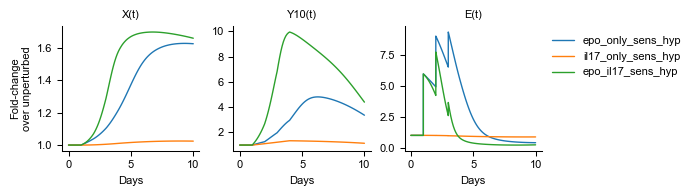

In [1863]:
## plot results of sensitivity tunning
plotting_features(results_sensitivity)
# plt.savefig('figures/sensitivity_tuning_dynamics.pdf', bbox_inches='tight')


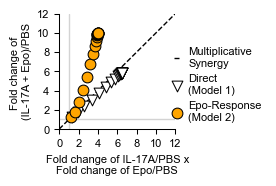

In [1865]:
plt.figure(figsize=(1.5,1.5))
lim=12
## Plotting the graph edges
plt.plot([0,lim],[0,lim], linestyle='--', label='Multiplicative\nSynergy', color='k')
plt.plot([0,lim],[1,1], linestyle='-', color='lightgrey')
plt.plot([1,1],[0,lim], linestyle='-', color='lightgrey')


t = np.where(results['epo_only_flux_hyp']['t']==4)[0]
for i in range(0,20,1):
    if i==10:
        j = 1
    else:
        j=0
    label_f = ['','Direct\n(Model 1)'][j]
    label_s = ['','Epo-Response\n(Model 2)'][j]
   
    plt.scatter(results['epo_only_flux_hyp']['y'][i][t]/results['epo_only_flux_hyp']['y'][i][0] * \
                results['il17_only_flux_hyp']['y'][i][t]/results['il17_only_flux_hyp']['y'][i][0],
                results['epo_il17_flux_hyp']['y'][i][t]/results['epo_il17_flux_hyp']['y'][i][0],
                zorder=10, color = 'white', label=label_f,marker = 'v',edgecolor='k',linewidth=0.75,
                s=60
               )

    plt.scatter(results_sensitivity['epo_only_sens_hyp']['y'][i][t]/results_sensitivity['epo_only_sens_hyp']['y'][i][0] * \
                results_sensitivity['il17_only_sens_hyp']['y'][i][t]/results_sensitivity['il17_only_sens_hyp']['y'][i][0],
                results_sensitivity['epo_il17_sens_hyp']['y'][i][t]/results_sensitivity['epo_il17_sens_hyp']['y'][i][0],
                color = 'orange',edgecolor='k',
                marker='o', s=60,
                linewidth=0.75,zorder=11, 
                label = label_s)
plt.ylim([0,lim])
plt.xticks(np.arange(0,lim+1,2))
plt.yticks(np.arange(0,lim+1,2))
plt.xlim([0,lim])
plt.legend(handlelength=0.5,loc='upper left',
           bbox_to_anchor = (0.9,0.8))


plt.xlabel('Fold change of IL-17A/PBS x\nFold change of Epo/PBS')
plt.ylabel('Fold change of \n(IL-17A + Epo)/PBS')
#plt.tight_layout()
plt.savefig('figures/Fig4F_using_Kr21_baseline_8_tuned_2_gmin_0.6_1_del_g_1.3.pdf', bbox_inches='tight')